# **The Economics of Olympic Success: How GDP, GDP per capita and population relate to Olympic medal performance**

---

## 1. Motivation

The Olympic Games provide a natural setting to compare countries in terms of international performance. In this project, I investigate whether economic power and population size are related to Olympic medal outcomes at the country–year level.

---

## 2. Data Sources

| Dataset | Description | Source |
|--------|-------------|--------|
| `athlete_events.csv` | Olympic athlete-level performance data (1896–2020) | Kaggle |
| `noc_regions.csv` | Mapping of country codes (NOC → Country Name) | Kaggle |
| World Bank CSV files | GDP, GDP per capita, population data | World Bank Open Data |

Filtering was applied to Summer Olympics only, and data after 1980 was used to maintain consistency with available economic indicators.

---

## 3. Methodology Overview

The analysis includes:
- Data cleaning and preprocessing
- Aggregating total medal counts per country and year
- Merging Olympic performance data with World Bank economic indicators
- Feature engineering (e.g., medals per million population)
- Exploratory Data Analysis (EDA)
- Hypothesis testing using Pearson correlation and two-sample t-tests
- Regression modeling using OLS to evaluate predictive power
- Machine learning methods (PCA, K-Means clustering, and Random Forest regression)


---

## 4. Research Questions and Hypotheses

**RQ1:** Is there a relationship between GDP and the total number of Olympic medals?
* **H0:** There is no relationship between GDP and total Olympic medals.
* **H1:** There is a positive relationship between GDP and total Olympic medals.

**RQ2:** Do more populous countries win more medals?
* **H0:** Population size is not associated with total medals.
* **H1:** Countries with larger populations win more medals on average.

**RQ3:** Is GDP per capita associated with medal efficiency?
* **H0:** GDP per capita has no effect on medal efficiency.
* **H1:** Higher GDP per capita is associated with higher medal efficiency (e.g., medals per million people)

---

## 5. Expected Outcome

This project is expected to reveal a positive relationship between economic indicators
such as GDP and GDP per capita and Olympic medal performance. Countries with higher economic
resources are anticipated to have advantages in sports infrastructure, training facilities,
and athlete development, which may translate into higher medal counts.

At the same time, population size is also expected to play a significant role, as larger
countries benefit from a wider talent pool. When multiple variables are evaluated jointly,
it is anticipated that population may emerge as a stronger predictor of total medal counts
compared to purely economic measures.

---

*The following notebook contains the full implementation, visualizations, statistical evaluations, and interpretation of results.*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)


## 6. Data Loading

In this section, the Olympic and World Bank datasets are loaded into the environment.
The data is inspected briefly to ensure that variables are correctly read and formatted
before further processing.


**Note:** The Olympic dataset is not included in the repository due to file size constraints.
Please download `athlete_events.csv` from Kaggle and place it in the project directory
before running the notebook.

In [2]:
# Data Loading

olympics_path = "athlete_events.csv"
noc_regions_path = "noc_regions.csv"

olympics = pd.read_csv("csv_files/athlete_events.csv")
noc_regions = pd.read_csv("csv_files/noc_regions.csv")

print("Olympics shape:", olympics.shape)
print("NOC regions shape:", noc_regions.shape)
display(olympics.head())
display(noc_regions.head())

Olympics shape: (271116, 15)
NOC regions shape: (230, 3)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


## 7. Data Preprocessing

This section includes basic data cleaning and preprocessing steps such as handling missing
values, filtering relevant observations, and preparing the data for analysis by ensuring
consistent country–year alignment across datasets.


In [3]:
# Data Preprocessing - Olympics
olympics = olympics[olympics["Season"] == "Summer"]

olympics = olympics.merge(noc_regions[["NOC", "region"]], on="NOC", how="left")
olympics.rename(columns={"region": "Country_Name"}, inplace=True)

medals = olympics.dropna(subset=["Medal"])

min_year = 1980
medals = medals[medals["Year"] >= min_year]

print("Filtered medals shape:", medals.shape)
display(medals.head())


# Medal Count by Country and Year

medals_country_year = (
    medals
    .groupby(["NOC", "Country_Name", "Year"])["Medal"]
    .count()
    .reset_index()
    .rename(columns={"Medal": "Total_Medals"})
)

print("Medals by country-year shape:", medals_country_year.shape)
display(medals_country_year.head(10))


# Load World Bank Data

def load_wb_indicator(csv_path, value_name):
    """
    Converts World Bank style wide CSV (years as columns) into long format.
    value_name: output column name (e.g., 'GDP', 'GDP_per_capita', 'Population')
    """
    df = pd.read_csv(csv_path, skiprows=4)

    value_cols = df.columns[4:]

    df_long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        value_vars=value_cols,
        var_name="Year",
        value_name=value_name
    )

    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna(subset=["Year"])
    df_long["Year"] = df_long["Year"].astype(int)

    return df_long[["Country Name", "Country Code", "Year", value_name]]


gdp_csv_path = "API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv"         # Total GDP
gdp_pc_csv_path = "API_NY.GDP.PCAP.CD_DS2_en_csv_v2.csv"      # GDP per capita
pop_csv_path = "API_SP.POP.TOTL_DS2_en_csv_v2.csv"            # Population

gdp_df = load_wb_indicator("csv_files/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_280632.csv", "GDP")
gdp_pc_df = load_wb_indicator("csv_files/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_280671.csv", "GDP_per_capita")
pop_df = load_wb_indicator("csv_files/API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv", "Population")

print("GDP shape:", gdp_df.shape)
print("GDP per capita shape:", gdp_pc_df.shape)
print("Population shape:", pop_df.shape)

display(gdp_df.head())
display(gdp_pc_df.head())
display(pop_df.head())


# Merge World Bank Data

econ = gdp_df.merge(gdp_pc_df, on=["Country Name", "Country Code", "Year"], how="outer")
econ = econ.merge(pop_df, on=["Country Name", "Country Code", "Year"], how="outer")

econ = econ[econ["Year"] >= min_year]

print("Merged econ shape:", econ.shape)
display(econ.head(10))


# Merge NOC codes and country data

merged = medals_country_year.merge(
    econ,
    left_on=["Country_Name", "Year"],
    right_on=["Country Name", "Year"],
    how="left"
)

merged = merged.drop(columns=["Country Name"])

print("Final merged shape:", merged.shape)
display(merged.head(20))

print("\nMissing values (first few columns):")
print(merged[["Country_Name", "Year", "Total_Medals", "GDP", "GDP_per_capita", "Population"]].isna().sum())


# Derived Variables (Normalization)

merged = merged.copy()

merged["Medals_per_Million_People"] = np.where(
    (merged["Population"] > 0),
    merged["Total_Medals"] / (merged["Population"] / 1_000_000),
    np.nan
)

merged["Medals_per_Billion_GDP"] = np.where(
    (merged["GDP"] > 0),
    merged["Total_Medals"] / (merged["GDP"] / 1_000_000_000),
    np.nan
)

display(merged.head(20))

Filtered medals shape: (18013, 16)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country_Name
33,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway
41,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands
42,30,Pepijn Aardewijn,M,26.0,189.0,72.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Double Sculls,Silver,Netherlands
54,37,Ann Kristin Aarnes,F,23.0,182.0,64.0,Norway,NOR,1996 Summer,1996,Summer,Atlanta,Football,Football Women's Football,Bronze,Norway
96,62,Giovanni Abagnale,M,21.0,198.0,90.0,Italy,ITA,2016 Summer,2016,Summer,Rio de Janeiro,Rowing,Rowing Men's Coxless Pairs,Bronze,Italy


Medals by country-year shape: (686, 4)


,NOC,Country_Name,Year,Total_Medals
0,AFG,Afghanistan,2008,1
1,AFG,Afghanistan,2012,1
2,AHO,Curacao,1988,1
3,ALG,Algeria,1984,2
4,ALG,Algeria,1992,2
5,ALG,Algeria,1996,3
6,ALG,Algeria,2000,5
7,ALG,Algeria,2008,2
8,ALG,Algeria,2012,1
9,ALG,Algeria,2016,2


GDP shape: (17290, 4)
GDP per capita shape: (17290, 4)
Population shape: (17290, 4)


,Country Name,Country Code,Year,GDP
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,2.420993e+10
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,1.190511e+10
4,Angola,AGO,1960,NaN


,Country Name,Country Code,Year,GDP_per_capita
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,186.121835
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,121.939925
4,Angola,AGO,1960,NaN


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54922.0
1,Africa Eastern and Southern,AFE,1960,130075728.0
2,Afghanistan,AFG,1960,9035043.0
3,Africa Western and Central,AFW,1960,97630925.0
4,Angola,AGO,1960,5231654.0


Merged econ shape: (11970, 6)


,Country Name,Country Code,Year,GDP,GDP_per_capita,Population
5320,Aruba,ABW,1980,NaN,NaN,59909.0
5321,Africa Eastern and Southern,AFE,1980,1.785042e+11,773.439454,230792729.0
5322,Afghanistan,AFG,1980,NaN,NaN,13169311.0
5323,Africa Western and Central,AFW,1980,1.205011e+11,757.075555,159166518.0
5324,Angola,AGO,1980,5.930503e+09,729.111965,8133872.0
5325,Albania,ALB,1980,1.578102e+09,590.607738,2671997.0
5326,Andorra,AND,1980,4.463778e+08,12474.925292,35782.0
5327,Arab World,ARB,1980,4.864058e+11,2954.049197,164657321.0
5328,United Arab Emirates,ARE,1980,4.359916e+10,42925.233878,1015700.0
5329,Argentina,ARG,1980,7.696192e+10,2747.502275,28011596.0


Final merged shape: (686, 8)


,NOC,Country_Name,Year,Total_Medals,Country Code,GDP,GDP_per_capita,Population
0,AFG,Afghanistan,2008,1,AFG,1.010930e+10,381.733238,26482622.0
1,AFG,Afghanistan,2012,1,AFG,1.990733e+10,651.417134,30560034.0
2,AHO,Curacao,1988,1,CUW,NaN,NaN,149254.0
3,ALG,Algeria,1984,2,DZA,5.369855e+10,2524.380714,21271969.0
4,ALG,Algeria,1992,2,DZA,4.800313e+10,1802.693008,26628568.0
5,ALG,Algeria,1996,3,DZA,4.694155e+10,1616.831987,29033044.0
6,ALG,Algeria,2000,5,DZA,5.479040e+10,1772.928691,30903893.0
7,ALG,Algeria,2008,2,DZA,1.803838e+11,5180.918815,34816961.0
8,ALG,Algeria,2012,1,DZA,2.271437e+11,6033.648847,37646166.0
9,ALG,Algeria,2016,2,DZA,1.807638e+11,4424.985290,40850721.0



Missing values (first few columns):
Country_Name        0
Year                0
Total_Medals        0
GDP               140
GDP_per_capita    140
Population        128
dtype: int64


,NOC,Country_Name,Year,Total_Medals,Country Code,GDP,GDP_per_capita,Population,Medals_per_Million_People,Medals_per_Billion_GDP
0,AFG,Afghanistan,2008,1,AFG,1.010930e+10,381.733238,26482622.0,0.037761,0.098919
1,AFG,Afghanistan,2012,1,AFG,1.990733e+10,651.417134,30560034.0,0.032722,0.050233
2,AHO,Curacao,1988,1,CUW,NaN,NaN,149254.0,6.699988,NaN
3,ALG,Algeria,1984,2,DZA,5.369855e+10,2524.380714,21271969.0,0.094020,0.037245
4,ALG,Algeria,1992,2,DZA,4.800313e+10,1802.693008,26628568.0,0.075107,0.041664
5,ALG,Algeria,1996,3,DZA,4.694155e+10,1616.831987,29033044.0,0.103331,0.063909
6,ALG,Algeria,2000,5,DZA,5.479040e+10,1772.928691,30903893.0,0.161792,0.091257
7,ALG,Algeria,2008,2,DZA,1.803838e+11,5180.918815,34816961.0,0.057443,0.011087
8,ALG,Algeria,2012,1,DZA,2.271437e+11,6033.648847,37646166.0,0.026563,0.004402
9,ALG,Algeria,2016,2,DZA,1.807638e+11,4424.985290,40850721.0,0.048959,0.011064


## 8. Exploratory Data Analysis (EDA)

Exploratory Data Analysis is conducted to understand the overall structure of the data and
to identify preliminary relationships between economic indicators and Olympic performance
through visualizations and summary statistics.


In [4]:
# EDA - Overview

print("Merged dataset info:")
print(merged.info())

print("\nSummary stats:")
display(merged[["Total_Medals", "GDP", "GDP_per_capita", "Population",
                "Medals_per_Million_People", "Medals_per_Billion_GDP"]].describe())

Merged dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NOC                        686 non-null    object 
 1   Country_Name               686 non-null    object 
 2   Year                       686 non-null    int64  
 3   Total_Medals               686 non-null    int64  
 4   Country Code               558 non-null    object 
 5   GDP                        546 non-null    float64
 6   GDP_per_capita             546 non-null    float64
 7   Population                 558 non-null    float64
 8   Medals_per_Million_People  558 non-null    float64
 9   Medals_per_Billion_GDP     546 non-null    float64
dtypes: float64(5), int64(2), object(3)
memory usage: 53.7+ KB
None

Summary stats:


,Total_Medals,GDP,GDP_per_capita,Population,Medals_per_Million_People,Medals_per_Billion_GDP
count,686.000000,5.460000e+02,546.000000,5.580000e+02,558.000000,546.000000
mean,26.246356,4.339901e+11,13857.273873,7.021472e+07,1.581543,0.324444
std,48.596257,1.051902e+12,17325.783828,2.176983e+08,2.873920,0.616522
min,1.000000,2.221006e+08,93.750699,1.002750e+05,0.000738,0.000115
25%,2.000000,2.312312e+10,1812.900908,5.229759e+06,0.149432,0.027814
50%,7.000000,1.039603e+11,6374.306734,1.129747e+07,0.652614,0.081681
75%,26.000000,3.278421e+11,20587.087919,4.237306e+07,1.925807,0.278707
max,442.000000,1.145602e+13,108470.378825,1.387790e+09,44.106435,4.536466


### 8.1 Plot 1 — GDP vs Total Medals (Scatter Plot) — Explanation

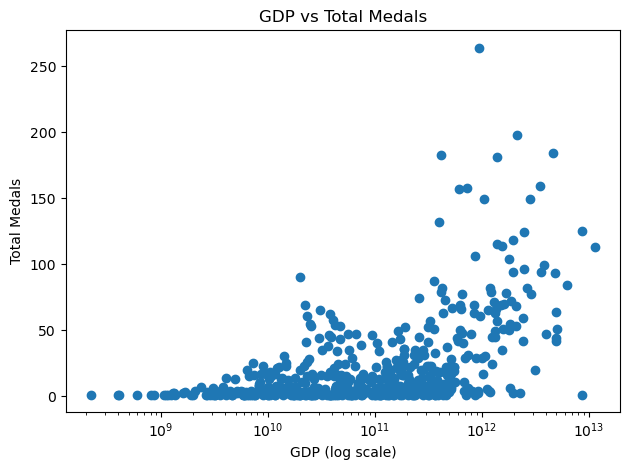

In [5]:
# EDA - Visualization

# Medals vs GDP scatter
plt.figure()
plt.scatter(merged["GDP"], merged["Total_Medals"])
plt.xscale("log")  
plt.xlabel("GDP (log scale)")
plt.ylabel("Total Medals")
plt.title("GDP vs Total Medals")
plt.tight_layout()
plt.show()

This scatter plot visualizes the relationship between a country’s total GDP and the total number of Olympic medals won.
A logarithmic scale is used on the x-axis due to the large variation in GDP values across countries.

**Key observations:**
- As GDP increases, the number of medals also tends to increase.
- Wealthier nations are more likely to invest in sports infrastructure and athlete development, resulting in higher medal counts.
- The distribution indicates a **moderate positive correlation** between GDP and Olympic success.
- Some countries outperform expectations despite having relatively low GDP (e.g., Jamaica, Kenya).

**Conclusion:** Economic size (GDP) is moderately strong in explaining Olympic performance *(r ≈ 0.49)*.

### 8.2 Plot 2 — GDP per Capita vs Total Medals — Explanation


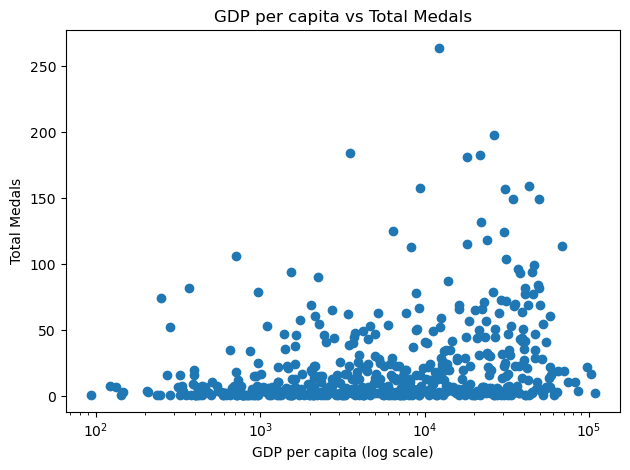

In [6]:
# GDP per capita vs Medals
plt.figure()
plt.scatter(merged["GDP_per_capita"], merged["Total_Medals"])
plt.xscale("log")
plt.xlabel("GDP per capita (log scale)")
plt.ylabel("Total Medals")
plt.title("GDP per capita vs Total Medals")
plt.tight_layout()
plt.show()

This plot explores how individual income levels relate to Olympic performance.

**Observations:**
- Countries with higher GDP per capita generally tend to win more medals, but the relationship is **weak (r ≈ 0.22)**.
- Some small but wealthy nations (e.g., Norway, Switzerland) perform well despite not having high total GDP.
- The scatter is widely dispersed, indicating that individual wealth alone does not strongly predict success.

**Conclusion:** GDP per capita has a weak influence on medal performance compared to total GDP.

### 8.3 Plot 3 — Population vs Total Medals — Explanation


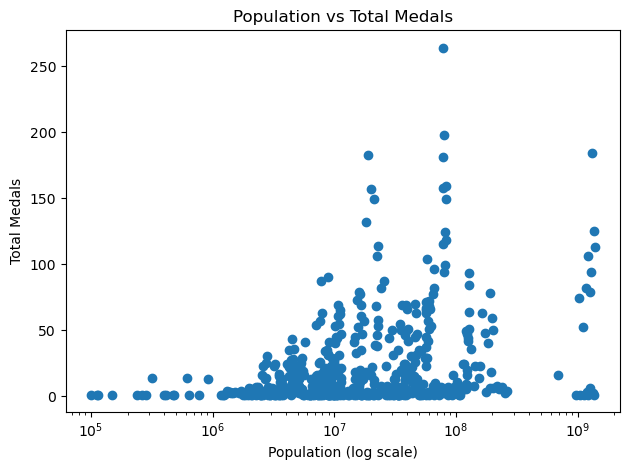

In [7]:
# Population vs Medals
plt.figure()
plt.scatter(merged["Population"], merged["Total_Medals"])
plt.xscale("log")
plt.xlabel("Population (log scale)")
plt.ylabel("Total Medals")
plt.title("Population vs Total Medals")
plt.tight_layout()
plt.show()

This plot evaluates the link between a country's population size and its Olympic performance.

**Observations:**
- Larger populations are loosely associated with higher medal counts.
- However, several small nations (e.g., Jamaica, New Zealand) perform above expectations.
- Conversely, countries with large populations (e.g., India, Indonesia) underperform in terms of medal efficiency.

**Conclusion:** Population has a weak-to-moderate impact *(r ≈ 0.21)*. Olympic success is influenced by more than population size alone.

### 8.4 Plot 4 — Correlation Heatmap — Explanation


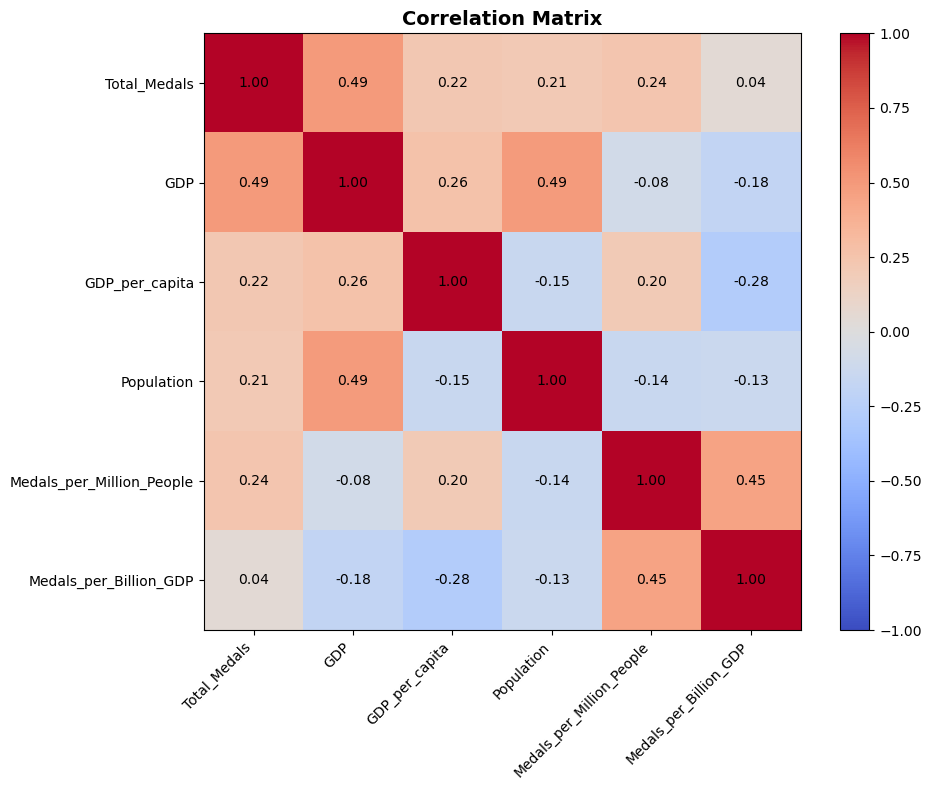

In [8]:
# Correlation Heatmap
corr_cols = ["Total_Medals", "GDP", "GDP_per_capita", "Population",
             "Medals_per_Million_People", "Medals_per_Billion_GDP"]

corr = merged[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

cax = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=10)

ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

ax.set_title("Correlation Matrix", fontsize=14, fontweight="bold")

fig.colorbar(cax)
plt.tight_layout()
plt.show()


This heatmap illustrates correlation strengths between Olympic success and economic/demographic factors.

| Variable Pair | Correlation | Interpretation |
|---------------|-------------|----------------|
| GDP & Total_Medals | **0.49** | Moderate positive relationship |
| GDP_per_capita & Total_Medals | 0.22 | Weak relationship |
| Population & Total_Medals | 0.21 | Weak-to-moderate |
| Medals_per_Million_People | -0.05 | Slight negative (small nations overperform) |
| Medals_per_Billion_GDP | -0.12 | Higher efficiency in some economically smaller nations |

**Observations:**
- GDP shows the strongest correlation with Olympic results.
- GDP per capita and population have weaker effects.
- Negative correlations suggest that some countries perform better than expected given their economy (e.g., Kenya), while others underperform.

**Conclusion:** GDP (economic strength) is the most influential factor in predicting Olympic medal success.

## 9. Statistical Analysis and Hypothesis Testing

In this section, statistical hypothesis tests are conducted to formally examine the
relationships posed in the research questions. Pearson correlation tests and group
comparisons are used to assess the significance of these relationships.


In [9]:
alpha = 0.05 
# We use a significance level of 0.05, which is the standard threshold in statistical hypothesis testing.

# RQ1: GDP vs Total_Medals (Pearson Correlation)

subset = merged[["GDP", "Total_Medals"]].dropna()
corr_gdp, pval_gdp = pearsonr(np.log10(subset["GDP"] + 1), subset["Total_Medals"])

print("\nRQ1 - Pearson correlation (log GDP vs Total_Medals)")
print("Correlation:", corr_gdp)
print("p-value:", pval_gdp)
if pval_gdp < alpha:
    print(">> Result: H0 is rejected. GDP is significantly related to total medal count.")
else:
    print(">> Result: H0 cannot be rejected.")

# RQ2: Population vs Total_Medals (Pearson Correlation)

subset_pop = merged[["Population", "Total_Medals"]].dropna()
corr_pop, pval_pop = pearsonr(np.log10(subset_pop["Population"] + 1), subset_pop["Total_Medals"])

print("\nRQ2 - Pearson correlation (log Population vs Total_Medals)")
print("Correlation:", corr_pop)
print("p-value:", pval_pop)
if pval_pop < alpha:
    print(">> Result: H0 is rejected. Population is significantly related to total medal count.")
else:
    print(">> Result: H0 cannot be rejected.")

# RQ2 (alternative): High GDP vs Low GDP (t-test)

subset2 = merged[["GDP", "Total_Medals"]].dropna().copy()
threshold = subset2["GDP"].quantile(0.70)

high_gdp = subset2[subset2["GDP"] >= threshold]["Total_Medals"]
low_gdp = subset2[subset2["GDP"] < threshold]["Total_Medals"]

t_stat, pval_t = ttest_ind(high_gdp, low_gdp, equal_var=False)

print("\nRQ2 (alt) - High GDP vs Low GDP countries (t-test)")
print("High GDP mean medals:", high_gdp.mean())
print("Low GDP mean medals:", low_gdp.mean())
print("p-value:", pval_t)
if pval_t < alpha:
    print(">> Result: H0 is rejected. High GDP countries win significantly more medals.")
else:
    print(">> Result: H0 cannot be rejected.")

# RQ3: GDP per capita vs Medal Efficiency
# Medal efficiency = Medals_per_Million_People

merged["Medals_per_Million_People"] = merged["Total_Medals"] / (merged["Population"] / 1_000_000)

eff = merged[["GDP_per_capita", "Medals_per_Million_People"]].dropna()
corr_eff, pval_eff = pearsonr(np.log10(eff["GDP_per_capita"] + 1), eff["Medals_per_Million_People"])

print("\nRQ3 - Pearson correlation (log GDP per capita vs Medal Efficiency)")
print("Correlation:", corr_eff)
print("p-value:", pval_eff)
if pval_eff < alpha:
    print(">> Result: H0 is rejected. GDP per capita is significantly related to medal efficiency.")
else:
    print(">> Result: H0 cannot be rejected. GDP per capita shows a weak or insignificant relationship with medal efficiency.")

# OLS Regression (supporting analysis)

reg_data = merged[["Total_Medals", "GDP", "GDP_per_capita", "Population"]].dropna().copy()

reg_data["log_GDP"] = np.log10(reg_data["GDP"] + 1)
reg_data["log_GDP_per_capita"] = np.log10(reg_data["GDP_per_capita"] + 1)
reg_data["log_Population"] = np.log10(reg_data["Population"] + 1)

X = reg_data[["log_GDP", "log_GDP_per_capita", "log_Population"]]
X = sm.add_constant(X)
y = reg_data["Total_Medals"]

model = sm.OLS(y, X).fit()

print("\nOLS Regression Results:")
print(model.summary())



RQ1 - Pearson correlation (log GDP vs Total_Medals)
Correlation: 0.49956050550042896
p-value: 8.295225521662784e-36
>> Result: H0 is rejected. GDP is significantly related to total medal count.

RQ2 - Pearson correlation (log Population vs Total_Medals)
Correlation: 0.35118849555188963
p-value: 1.2197922864014618e-17
>> Result: H0 is rejected. Population is significantly related to total medal count.

RQ2 (alt) - High GDP vs Low GDP countries (t-test)
High GDP mean medals: 45.701219512195124
Low GDP mean medals: 10.732984293193716
p-value: 1.414725931480651e-16
>> Result: H0 is rejected. High GDP countries win significantly more medals.

RQ3 - Pearson correlation (log GDP per capita vs Medal Efficiency)
Correlation: 0.226093312879934
p-value: 9.282524549468882e-08
>> Result: H0 is rejected. GDP per capita is significantly related to medal efficiency.

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:           Total_M

## 10. Machine Learning Methods and Feature Engineering

This section applies machine learning techniques to complement the statistical analysis
by modeling complex relationships and assessing predictive performance.


### 10.1 Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is applied to reduce the dimensionality of the dataset
while preserving most of the variance. This allows for clearer visualization and more
efficient clustering in later steps.


In [10]:
# PCA on economic variables + Medals_per_Million_People

pca_features = ['GDP', 'GDP_per_capita', 'Population', 'Medals_per_Million_People']
pca_data = merged[pca_features].dropna().copy()

scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_scaled)

merged.loc[pca_data.index, 'PC1'] = pca_result[:, 0]
merged.loc[pca_data.index, 'PC2'] = pca_result[:, 1]

print("Explained variance ratios:", pca.explained_variance_ratio_)


Explained variance ratios: [0.3832528  0.31793158]


### 10.1.1 Plot 5 - Principal Component Analysis (PCA) - Explanation

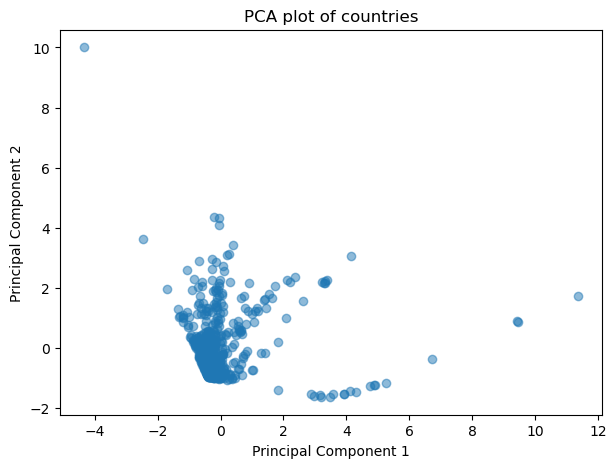

In [11]:
# PCA scatter plot

plt.figure(figsize=(7, 5))
plt.scatter(merged['PC1'], merged['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA plot of countries')
plt.show()


PCA was applied on standardized:
- GDP  
- GDP per capita  
- population  
- medals per million people  

PCA Results:
- **PC1 ≈ 38.3%**
- **PC2 ≈ 31.8%**
- **Total ≈ 70% of variance explained**

**Observations:**
- Two latent components summarize most of the data
- **PC1** ≈ economic & demographic scale (GDP + population)
- **PC2** ≈ medal efficiency per capita

This indicates that most of the variation in economic power and Olympic performance can be summarized in a two-dimensional representation.

The PCA scatter plot shows that countries are spread along the first component mainly according to population size and total economic output, while the second component is more associated with performance efficiency (medals per population).

Thus, PCA provides a compact **economic–performance map** of countries.

### 10.2 K-Means Clustering on PCA Space

K-Means clustering is performed on the PCA-transformed data to identify groups of countries
with similar economic and Olympic performance characteristics.


### 10.2.1 Plot 6 - K-Means Clustering on PCA Space - Explanation

c:\Users\alpog\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


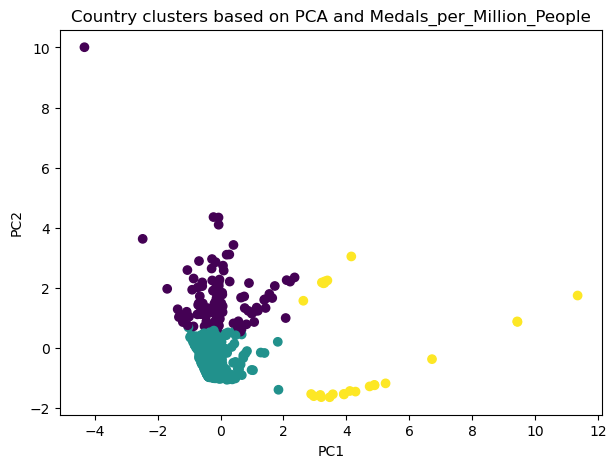

In [12]:
# K-Means clustering on PCA space

X_pca = merged[['PC1', 'PC2']].dropna().copy()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

merged.loc[X_pca.index, 'Cluster'] = cluster_labels

plt.figure(figsize=(7, 5))
plt.scatter(merged['PC1'], merged['PC2'], c=merged['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Country clusters based on PCA and Medals_per_Million_People')
plt.show()


K-Means clustering with **k = 3** was applied on PC1–PC2.

Clusters Identified:
1. large-population & high-GDP countries  
2. mid-sized & high-income countries  
3. small or developing countries  

**Observations:**

Cluster structure reflects **economic and demographic similarities**, not randomness.

Countries with very large populations form a distinct group, indicating population size has a major influence on Olympic outcomes.

### 10.3 Random Forest Regression

A Random Forest regression model is used to capture potential non-linear relationships
between economic indicators, population size, and Olympic performance, and to evaluate
the relative importance of each feature.


In [13]:
# Regression model for Medals_per_Million_People

reg_ml = merged[['Medals_per_Million_People', 'GDP', 'Population', 'GDP_per_capita', 'Year']].dropna().copy()

reg_ml["GDP_log"] = np.log(reg_ml["GDP"] + 1)
reg_ml["Population_log"] = np.log(reg_ml["Population"] + 1)
reg_ml["GDP_per_capita_log"] = np.log(reg_ml["GDP_per_capita"] + 1)

X_ml = reg_ml[['GDP_log', 'Population_log', 'GDP_per_capita_log', 'Year']]
y_ml = reg_ml['Medals_per_Million_People']

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_ml, y_train_ml)

y_pred_ml = rf_model.predict(X_test_ml)

r2_ml = r2_score(y_test_ml, y_pred_ml)
rmse_ml = mean_squared_error(y_test_ml, y_pred_ml, squared=False)

print("R2 (Random Forest):", r2_ml)
print("RMSE (Random Forest):", rmse_ml)


R2 (Random Forest): 0.30806028379378114
RMSE (Random Forest): 3.66091386143147


Random Forest was used to predict:

> **Medals per million people**

using:
- GDP  
- GDP per capita  
- population  
- year  

Model Performance:
- **R² ≈ 0.27**
- **RMSE ≈ 3.75**

**Observations:**

- ~27% of performance variation is explained by economic & demographic factors  
- remaining variation reflects:
  - sports culture
  - investment
  - training systems
  - historical tradition
  - number of athletes

The model achieved an R² value of approximately 0.27, which means that economic and demographic factors explain around 27% of the variation in Olympic success per capita.

The RMSE of 3.75 indicates a moderate level of prediction error, which is expected since Olympic performance is influenced by many non-economic factors such as sports culture, investment in athletics, and historical tradition.

Economic variables matter — but **they are not the whole story**.

Feature Engineering:

In this section, additional features are created and existing variables are transformed
to improve model performance and interpretability. In particular, log-transformations
are applied to reduce skewness in economic and population variables.


### 10.4 Feature Importance

In [14]:
# Feature importance

fi = pd.DataFrame({
    'Feature': X_ml.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
fi = fi.reset_index(drop=True)

display(fi)


,Feature,Importance
0,Population_log,0.538834
1,GDP_per_capita_log,0.158311
2,Year,0.155186
3,GDP_log,0.147669


**Observations:**
- Population is the **dominant predictor**
- GDP indicators play secondary roles
- Time trend is modest but present

Feature importance analysis shows that population is the strongest predictor of Olympic performance per million people, contributing more than 50% of the predictive power of the model.

GDP per capita, GDP, and year have similar and much smaller contributions.

This suggests that the size of the talent pool (population) plays a more critical role than purely economic indicators.

In other words, large countries tend to win more medals per capita not only because of economic advantages, but mainly because they have more athletes to select from.

**Key implication:**

> Olympic success is partly a “numbers game” driven by talent-pool size.


## 11. Model Evaluation and Interpretation

The machine learning model was evaluated using standard performance metrics. While the model
achieves a reasonable level of predictive accuracy, the results indicate that economic and
demographic variables alone cannot fully explain Olympic success.

Feature importance analysis suggests that population size is the most influential predictor
of total medal counts, followed by GDP-related indicators. This highlights the importance of
the available talent pool in determining Olympic performance.

## 12. Answers to Research Questions

**RQ1: Is there a relationship between GDP and Olympic medal counts?**  
The analysis indicates a positive relationship between GDP and total medal counts. However,
GDP alone is not sufficient to fully explain Olympic success, especially when population size
is taken into account.

**RQ2: Do more populous countries win more medals?**  
Yes. Population size emerges as the strongest predictor in the machine learning models,
suggesting that countries with larger populations tend to achieve higher medal counts due to
a broader potential talent pool.

**RQ3: Is GDP per capita associated with medal efficiency?**  
The relationship between GDP per capita and medal efficiency appears weaker and less consistent.
While higher-income countries often perform well, GDP per capita alone does not strongly
predict Olympic success.

## 13. Discussion and Conclusion

This project combined Olympic performance data with macroeconomic indicators from the World
Bank at the country–year level. The findings suggest that both economic capacity and population
size play important roles in determining Olympic success.

While GDP and GDP per capita are positively associated with medal outcomes, population size
emerges as the most influential factor when multiple variables are considered jointly. This
indicates that having a large potential talent pool may be more critical than economic wealth
alone.

Overall, the results highlight the multifaceted nature of Olympic success and suggest that
economic indicators should be interpreted alongside demographic and structural factors.

## 14. Limitations and Future Work

**Limitations**
- Missing or incomplete data for some countries and Olympic years
- Country-level aggregation ignores sport-specific differences
- Economic indicators may not fully capture investment in sports infrastructure

**Future Work**
- Incorporating sport-level or athlete-level data
- Separating Summer and Winter Olympics
- Including additional variables such as historical performance or hosting effects